## CSC-180 Project 1
##### By: Derek Chen, Nicolas Gueliemo, Xai Yang, Katrina Yu

### Imports & Provided Functions from Lab

In [9]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


### Original Code
#### Includes:
- Spliting Data into Training & Testing for Models
- Using TF-IDF to extract features
- Implementing Early Stopping for training with TensorFlow
- Showing inital RMSE

In [10]:
# Original Code
# Author: Nicolas Gugliemo, Katrina Yu
# Date: 9/16/2024
# Project: Project 1 Yelp Business Rating Prediction using Tensorflow
# Goal: Predict Business's stars rating... 

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

# You may use the following code to group ALL the reviews by each business and create a new
# dataframe, where each line is a business with all its reviews aggregated together. From there,
# you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

# Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) without Rounding: {}".format(score))

# Rounding up predicted values to .5
for i in pred:
    if i[0] < 5:
        i[0] = round(i[0]*2)/2
    if i[0] > 5:
        i[0] = 5

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) with Rounding: {}".format(score))


REG
Epoch 1/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 18ms/step - loss: 3.1267 - val_loss: 0.5477
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.4441 - val_loss: 0.3524
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.2940 - val_loss: 0.3719
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.2360 - val_loss: 0.3793
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.1903 - val_loss: 0.3911
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.1669 - val_loss: 0.4122
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.1427 - val_loss: 0.4084
Epoch 8/1000
136/136 - 0s - 4ms/step - loss: 0.1302 - val_loss: 0.4193
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1210 - val_loss: 0.4217
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.1039 - val_loss: 0.4278
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.0985 - val_loss: 0.4257
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.0895 - val_loss: 0.4385
Epoch 12: early stopping
Epoch 1/1000
136/136 - 2s - 16ms/step - loss: 2.5882 - val_loss: 0.4780
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.4086 - val_lo

### Finding the best Model with the best RMSE
Testing with different combinations & numbers of the following:
- Activation: relu, sigmoid, tanh
- Number of layers and neuron count for each layer
- Optimizer: adam and sgd.

### & Displaying 5 different random businesses actual stars & predicted stars Using the best Model from above

REG


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 16ms/step - loss: 2.5042 - val_loss: 0.5643
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.4611 - val_loss: 0.3680
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.3060 - val_loss: 0.3706
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.2535 - val_loss: 0.3875
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.2172 - val_loss: 0.3951
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.1912 - val_loss: 0.4125
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.1735 - val_loss: 0.4139
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1680 - val_loss: 0.4430
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1507 - val_loss: 0.4456
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.1443 - val_loss: 0.4463
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.1271 - val_loss: 0.4435
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.1242 - val_loss: 0.4524
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[2.7691798]
 [3.5355077]
 [2.5362046]
 ...
 [4.6575685]
 [3.6809924]
 [3.915605

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.5144 - val_loss: 0.6119
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.7083 - val_loss: 0.5768
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.6573 - val_loss: 0.5455
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.6068 - val_loss: 0.4919
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.5452 - val_loss: 0.4451
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.4756 - val_loss: 0.4233
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.4399 - val_loss: 0.3664
Epoch 8/1000
136/136 - 0s - 4ms/step - loss: 0.4072 - val_loss: 0.3436
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3735 - val_loss: 0.3732
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3607 - val_loss: 0.3177
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.3473 - val_loss: 0.3132
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.3320 - val_loss: 0.3065
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.3258 - val_loss: 0.3007
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.3142 - val_loss: 0.3131
Epoch 15/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 20ms/step - loss: 2.4499 - val_loss: 0.4377
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.4924 - val_loss: 0.3801
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.3611 - val_loss: 0.3538
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.3166 - val_loss: 0.3801
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.2874 - val_loss: 0.3783
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.2494 - val_loss: 0.3809
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.2233 - val_loss: 0.3902
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.2136 - val_loss: 0.4043
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1995 - val_loss: 0.3999
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.1815 - val_loss: 0.3844
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.1673 - val_loss: 0.3998
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.1616 - val_loss: 0.3891
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.1554 - val_loss: 0.3891
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[3.2381

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.6151 - val_loss: 0.6110
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.7674 - val_loss: 0.5830
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.6994 - val_loss: 0.5351
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.6482 - val_loss: 0.4749
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.5367 - val_loss: 0.4136
Epoch 6/1000
136/136 - 0s - 4ms/step - loss: 0.4842 - val_loss: 0.3594
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.4262 - val_loss: 0.3381
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.4011 - val_loss: 0.3246
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3870 - val_loss: 0.3140
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3634 - val_loss: 0.3118
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.3476 - val_loss: 0.3304
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.3332 - val_loss: 0.2984
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.3251 - val_loss: 0.2981
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.3091 - val_loss: 0.2954
Epoch 15/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 19ms/step - loss: 2.1686 - val_loss: 0.3776
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.4461 - val_loss: 0.3482
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.3409 - val_loss: 0.3602
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.2995 - val_loss: 0.3764
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.2677 - val_loss: 0.4134
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.2315 - val_loss: 0.3815
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.2109 - val_loss: 0.3948
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.2111 - val_loss: 0.4095
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.1956 - val_loss: 0.4393
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.1945 - val_loss: 0.4202
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.1810 - val_loss: 0.3942
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.1755 - val_loss: 0.3924
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[2.891412 ]
 [3.4874177]
 [2.5442095]
 ...
 [4.5142317]
 [3.4111865]
 [3.7328007]]
Score (RM

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 8ms/step - loss: 1.2980 - val_loss: 0.6041
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.7501 - val_loss: 0.5696
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.6523 - val_loss: 0.4886
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.5791 - val_loss: 0.4178
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.4937 - val_loss: 0.4622
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.4450 - val_loss: 0.3809
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.4031 - val_loss: 0.3461
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3905 - val_loss: 0.3123
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3666 - val_loss: 0.3093
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.3645 - val_loss: 0.3027
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.3456 - val_loss: 0.3077
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.3285 - val_loss: 0.3352
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.3207 - val_loss: 0.3420
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.3039 - val_loss: 0.5476
Epoch 15/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 17ms/step - loss: 2.0596 - val_loss: 0.3815
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.3571 - val_loss: 0.3431
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.2662 - val_loss: 0.3672
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.2106 - val_loss: 0.3899
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.1768 - val_loss: 0.3907
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.1530 - val_loss: 0.4084
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.1337 - val_loss: 0.4093
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1239 - val_loss: 0.4352
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1155 - val_loss: 0.4194
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.1048 - val_loss: 0.4166
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.1007 - val_loss: 0.3920
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.0884 - val_loss: 0.4007
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[3.1065726]
 [3.6104794]
 [2.5086806]
 ...
 [4.875592 ]
 [3.6560292]
 [4.0744853]]
Score (RM

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 12ms/step - loss: 1.5532 - val_loss: 0.6286
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.7178 - val_loss: 0.6055
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.6729 - val_loss: 0.5706
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.6331 - val_loss: 0.5608
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.5625 - val_loss: 0.4545
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.4743 - val_loss: 0.4340
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.4176 - val_loss: 0.3448
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3742 - val_loss: 0.3265
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3527 - val_loss: 0.3576
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3355 - val_loss: 0.3308
Epoch 11/1000
136/136 - 0s - 4ms/step - loss: 0.3207 - val_loss: 0.3013
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.3032 - val_loss: 0.3123
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.2926 - val_loss: 0.2963
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2837 - val_loss: 0.3086
Epoch 15/1000

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 27ms/step - loss: 2.1930 - val_loss: 0.4460
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.5805 - val_loss: 0.3700
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.4279 - val_loss: 0.3507
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.3804 - val_loss: 0.3593
Epoch 5/1000
136/136 - 2s - 11ms/step - loss: 0.3130 - val_loss: 0.3572
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.2872 - val_loss: 0.3864
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.2420 - val_loss: 0.3590
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.2271 - val_loss: 0.3817
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.2172 - val_loss: 0.3540
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.1999 - val_loss: 0.3701
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.1842 - val_loss: 0.3580
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.1775 - val_loss: 0.3563
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.1829 - val_loss: 0.3546
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[3.073

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 15ms/step - loss: 1.4058 - val_loss: 0.6265
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.8175 - val_loss: 0.5890
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.7282 - val_loss: 0.5145
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.6122 - val_loss: 0.4242
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.5260 - val_loss: 0.3548
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.4781 - val_loss: 0.3805
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.4377 - val_loss: 0.3164
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.4122 - val_loss: 0.3156
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.4026 - val_loss: 0.3531
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.3666 - val_loss: 0.3932
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.3522 - val_loss: 0.4035
Epoch 12/1000
136/136 - 0s - 4ms/step - loss: 0.3391 - val_loss: 0.3295
Epoch 13/1000
136/136 - 0s - 4ms/step - loss: 0.3299 - val_loss: 0.2935
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.3155 - val_loss: 0.3387


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 15ms/step - loss: 1.1577 - val_loss: 0.6014
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.6964 - val_loss: 0.5280
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.5928 - val_loss: 0.4356
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.4705 - val_loss: 0.3538
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.3966 - val_loss: 0.3144
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.3368 - val_loss: 0.2997
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.3193 - val_loss: 0.2916
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.2973 - val_loss: 0.2886
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.2856 - val_loss: 0.2905
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.2704 - val_loss: 0.3007
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.2526 - val_loss: 0.2905
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.2458 - val_loss: 0.2919
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.2417 - val_loss: 0.2992
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.2279 - val_loss: 0.2994
Epoch 15/1000

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 6ms/step - loss: 0.9222 - val_loss: 0.6475
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.7714 - val_loss: 0.6467
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.7667 - val_loss: 0.6488
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.7521 - val_loss: 0.6463
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.7377 - val_loss: 0.6503
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.7325 - val_loss: 0.6469
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.7301 - val_loss: 0.6624
Epoch 8/1000
136/136 - 0s - 4ms/step - loss: 0.7361 - val_loss: 0.6475
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.7377 - val_loss: 0.6469
Epoch 10/1000
136/136 - 0s - 4ms/step - loss: 0.7265 - val_loss: 0.6454
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.7275 - val_loss: 0.6546
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.7295 - val_loss: 0.6450
Epoch 13/1000
136/136 - 0s - 2ms/step - loss: 0.7209 - val_loss: 0.6683
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.7188 - val_loss: 0.6774
Epoch 15/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 19ms/step - loss: 2.3740 - val_loss: 0.6444
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.8569 - val_loss: 0.6426
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.8358 - val_loss: 0.6362
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.8196 - val_loss: 0.6277
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.8019 - val_loss: 0.6078
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.7628 - val_loss: 0.5490
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.6393 - val_loss: 0.4015
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.4738 - val_loss: 0.3269
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.4138 - val_loss: 0.3028
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.3847 - val_loss: 0.2954
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.3548 - val_loss: 0.2913
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.3413 - val_loss: 0.2892
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.3220 - val_loss: 0.2856
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.3127 - val_loss: 0.2904
Epoch 15/1000

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.1501 - val_loss: 0.6537
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.8019 - val_loss: 0.6458
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.7838 - val_loss: 0.6513
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.7640 - val_loss: 0.6480
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.7587 - val_loss: 0.6463
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.7616 - val_loss: 0.6469
Epoch 7/1000
136/136 - 0s - 2ms/step - loss: 0.7430 - val_loss: 0.6466
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.7511 - val_loss: 0.6458
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.7456 - val_loss: 0.6463
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.7465 - val_loss: 0.6457
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.7353 - val_loss: 0.6487
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.7294 - val_loss: 0.6475
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[3.6099539]
 [3.610737 ]
 [3.6099951]
 ...
 [3.609971 ]
 [3.610592 ]
 [3.6103218]]
Score (RMS

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 19ms/step - loss: 1.4026 - val_loss: 0.6399
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.8259 - val_loss: 0.6381
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.7869 - val_loss: 0.6043
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.7319 - val_loss: 0.5247
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.5737 - val_loss: 0.3556
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.4225 - val_loss: 0.3065
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.3726 - val_loss: 0.2982
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.3545 - val_loss: 0.2882
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.3269 - val_loss: 0.3004
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.3098 - val_loss: 0.2875
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.2902 - val_loss: 0.2899
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.2873 - val_loss: 0.2975
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.2727 - val_loss: 0.2947
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.2658 - val_loss: 0.3055
Epoch 15/1000

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 10ms/step - loss: 1.1372 - val_loss: 0.6462
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.8199 - val_loss: 0.6510
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.8002 - val_loss: 0.6475
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.7742 - val_loss: 0.6566
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.7727 - val_loss: 0.6461
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.7524 - val_loss: 0.6482
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.7674 - val_loss: 0.6486
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.7507 - val_loss: 0.6517
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.7540 - val_loss: 0.6528
Epoch 10/1000
136/136 - 0s - 4ms/step - loss: 0.7466 - val_loss: 0.6469
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.7587 - val_loss: 0.6479
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[3.5879943]
 [3.5888257]
 [3.588598 ]
 ...
 [3.588857 ]
 [3.5882375]
 [3.589298 ]]
Score (RMSE): 0.8038017749786377
Epoch 1/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 17ms/step - loss: 1.6810 - val_loss: 0.6362
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.7417 - val_loss: 0.6185
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.7049 - val_loss: 0.5682
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.6126 - val_loss: 0.4404
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.4459 - val_loss: 0.3297
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.3640 - val_loss: 0.3054
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.3295 - val_loss: 0.2999
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.3015 - val_loss: 0.2895
Epoch 9/1000
136/136 - 0s - 4ms/step - loss: 0.2814 - val_loss: 0.2897
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.2646 - val_loss: 0.2878
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.2579 - val_loss: 0.2882
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.2440 - val_loss: 0.2964
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.2341 - val_loss: 0.2995
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.2172 - val_loss: 0.2959
Epoch 15/1000

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 8ms/step - loss: 0.9455 - val_loss: 0.6641
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.7571 - val_loss: 0.6955
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.7528 - val_loss: 0.7195
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.7501 - val_loss: 0.6466
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.7411 - val_loss: 0.6590
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.7363 - val_loss: 0.6559
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.7262 - val_loss: 0.6477
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.7246 - val_loss: 0.6577
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.7261 - val_loss: 0.6489
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.7174 - val_loss: 0.6550
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.7198 - val_loss: 0.6544
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.7138 - val_loss: 0.6549
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.7243 - val_loss: 0.6467
Epoch 14/1000
136/136 - 0s - 2ms/step - loss: 0.7306 - val_loss: 0.6685
Epoch 14: earl

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 23ms/step - loss: 3.9739 - val_loss: 0.7747
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.8391 - val_loss: 0.6466
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.8161 - val_loss: 0.6462
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.8357 - val_loss: 0.6464
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.8348 - val_loss: 0.6457
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.8031 - val_loss: 0.6461
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.8223 - val_loss: 0.6465
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.8004 - val_loss: 0.6457
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.8188 - val_loss: 0.6457
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.8297 - val_loss: 0.6472
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.8048 - val_loss: 0.6459
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.8148 - val_loss: 0.6462
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[3.6081805]
 [3.6082249]
 [3.6082492]
 ...
 [3.6083002]
 [3.6083083]
 [3.608336 ]]
Score (RM

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 12ms/step - loss: 0.9619 - val_loss: 0.6468
Epoch 2/1000
136/136 - 0s - 4ms/step - loss: 0.7967 - val_loss: 0.6457
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.7977 - val_loss: 0.6532
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.8002 - val_loss: 0.6556
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.7649 - val_loss: 0.6457
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.7747 - val_loss: 0.6475
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.7624 - val_loss: 0.6467
Epoch 8/1000
136/136 - 0s - 4ms/step - loss: 0.7704 - val_loss: 0.6465
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.7581 - val_loss: 0.6483
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.7552 - val_loss: 0.6479
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.7449 - val_loss: 0.6457
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.7326 - val_loss: 0.6513
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[3.606849 ]
 [3.6068494]
 [3.6068776]
 ...
 [3.6067948]
 [3.606789 ]
 [3.6068656]]
Score (RM

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 16ms/step - loss: 1.5888 - val_loss: 0.4052
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.3442 - val_loss: 0.3459
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.2531 - val_loss: 0.3406
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.2156 - val_loss: 0.3655
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.1972 - val_loss: 0.3884
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.1758 - val_loss: 0.4081
Epoch 7/1000
136/136 - 0s - 4ms/step - loss: 0.1693 - val_loss: 0.4317
Epoch 8/1000
136/136 - 0s - 4ms/step - loss: 0.1503 - val_loss: 0.4482
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1508 - val_loss: 0.4577
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.1367 - val_loss: 0.4655
Epoch 11/1000
136/136 - 0s - 4ms/step - loss: 0.1356 - val_loss: 0.4791
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.1278 - val_loss: 0.4818
Epoch 13/1000
136/136 - 0s - 4ms/step - loss: 0.1183 - val_loss: 0.4905
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[2.5585067]
 [3.1982

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.0757 - val_loss: 0.6149
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.6631 - val_loss: 0.5586
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.5867 - val_loss: 0.4973
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.5323 - val_loss: 0.4329
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.4589 - val_loss: 0.3830
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.4020 - val_loss: 0.3557
Epoch 7/1000
136/136 - 0s - 2ms/step - loss: 0.3758 - val_loss: 0.3337
Epoch 8/1000
136/136 - 0s - 2ms/step - loss: 0.3475 - val_loss: 0.3632
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3258 - val_loss: 0.3111
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3215 - val_loss: 0.3099
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.2999 - val_loss: 0.3023
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.2937 - val_loss: 0.2973
Epoch 13/1000
136/136 - 0s - 2ms/step - loss: 0.2817 - val_loss: 0.3082
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2707 - val_loss: 0.3139
Epoch 15/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 17ms/step - loss: 1.3978 - val_loss: 0.3796
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.4441 - val_loss: 0.2984
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.3611 - val_loss: 0.3184
Epoch 4/1000
136/136 - 0s - 4ms/step - loss: 0.2889 - val_loss: 0.3371
Epoch 5/1000
136/136 - 0s - 4ms/step - loss: 0.2661 - val_loss: 0.3526
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.2394 - val_loss: 0.3549
Epoch 7/1000
136/136 - 0s - 4ms/step - loss: 0.2225 - val_loss: 0.3818
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.2039 - val_loss: 0.3905
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1977 - val_loss: 0.4038
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.1757 - val_loss: 0.4024
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.1705 - val_loss: 0.4299
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.1603 - val_loss: 0.4293
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[2.528032 ]
 [3.5498197]
 [2.5385423]
 ...
 [4.3846574]
 [3.4890924]
 [4.1214375]]
Score (RM

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.1161 - val_loss: 0.6162
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.7178 - val_loss: 0.5780
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.6668 - val_loss: 0.5242
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.5845 - val_loss: 0.4876
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.4791 - val_loss: 0.3692
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.4089 - val_loss: 0.3403
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.3673 - val_loss: 0.3346
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3576 - val_loss: 0.3117
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3301 - val_loss: 0.3839
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.3182 - val_loss: 0.3763
Epoch 11/1000
136/136 - 0s - 4ms/step - loss: 0.3143 - val_loss: 0.2976
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.2993 - val_loss: 0.5848
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.2890 - val_loss: 0.3017
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2832 - val_loss: 0.3206
Epoch 15/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 18ms/step - loss: 1.3061 - val_loss: 0.3145
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.3812 - val_loss: 0.3122
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.3040 - val_loss: 0.3317
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.2656 - val_loss: 0.3564
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.2316 - val_loss: 0.3743
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.2153 - val_loss: 0.4063
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.1898 - val_loss: 0.4136
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1745 - val_loss: 0.4198
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.1686 - val_loss: 0.4453
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.1567 - val_loss: 0.4497
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.1498 - val_loss: 0.4591
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.1388 - val_loss: 0.4505
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2.7986534]
 [3.4269054]
 [2.792171 ]
 ...
 [4.4226446]
 [3.652085 ]
 [3.9334865]]
Score (RM

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 0.9268 - val_loss: 0.5833
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.6669 - val_loss: 0.5438
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.5396 - val_loss: 0.3985
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.4388 - val_loss: 0.4572
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.3911 - val_loss: 0.3189
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.3597 - val_loss: 0.3826
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.3441 - val_loss: 0.3061
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3268 - val_loss: 0.3077
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3156 - val_loss: 0.3083
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3106 - val_loss: 0.3020
Epoch 11/1000
136/136 - 0s - 4ms/step - loss: 0.3013 - val_loss: 0.2958
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.2944 - val_loss: 0.3072
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.2640 - val_loss: 0.5739
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2664 - val_loss: 0.3748
Epoch 15/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 18ms/step - loss: 1.3382 - val_loss: 0.3681
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.3095 - val_loss: 0.3219
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.2384 - val_loss: 0.3498
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.2030 - val_loss: 0.3812
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.1786 - val_loss: 0.4023
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.1620 - val_loss: 0.4058
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.1570 - val_loss: 0.4257
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.1327 - val_loss: 0.4210
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.1281 - val_loss: 0.4484
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.1161 - val_loss: 0.4788
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.1130 - val_loss: 0.4626
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.1022 - val_loss: 0.4840
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[2.6755872]
 [3.1574028]
 [2.687431 ]
 ...
 [4.697396 ]
 [3.8628197]
 [3.86518  ]]
Score (RM

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.0262 - val_loss: 0.5966
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.6415 - val_loss: 0.5332
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.5647 - val_loss: 0.4951
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.4538 - val_loss: 0.3810
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.3796 - val_loss: 0.3616
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.3411 - val_loss: 0.3188
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.3298 - val_loss: 0.3613
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3144 - val_loss: 0.3658
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.2961 - val_loss: 0.3044
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.2853 - val_loss: 0.3000
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.2741 - val_loss: 0.3414
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.2667 - val_loss: 0.3065
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.2620 - val_loss: 0.3365
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2559 - val_loss: 0.3048
Epoch 15/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 24ms/step - loss: 1.2070 - val_loss: 0.3222
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.4413 - val_loss: 0.3083
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.3395 - val_loss: 0.3283
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.2907 - val_loss: 0.3822
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.2586 - val_loss: 0.3372
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.2493 - val_loss: 0.3935
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.2327 - val_loss: 0.3613
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.2009 - val_loss: 0.3859
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.2027 - val_loss: 0.3964
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.1898 - val_loss: 0.4640
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.1714 - val_loss: 0.4145
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.1703 - val_loss: 0.4346
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[2.3723984]
 [3.943959 ]
 [2.5196853]
 ...
 [4.536209 ]
 [3.5202413]
 [4.164976

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 10ms/step - loss: 0.9992 - val_loss: 0.6142
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.7441 - val_loss: 0.5373
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.6170 - val_loss: 0.4474
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.5167 - val_loss: 0.3793
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.4618 - val_loss: 0.3578
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.4088 - val_loss: 0.3157
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.3937 - val_loss: 0.7572
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3675 - val_loss: 0.3310
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.3525 - val_loss: 0.3588
Epoch 10/1000
136/136 - 0s - 4ms/step - loss: 0.3273 - val_loss: 0.5564
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.3193 - val_loss: 0.3221
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.3037 - val_loss: 0.4454
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.2939 - val_loss: 0.3034
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.2912 - val_loss: 0.2924
Epoch 15/1000

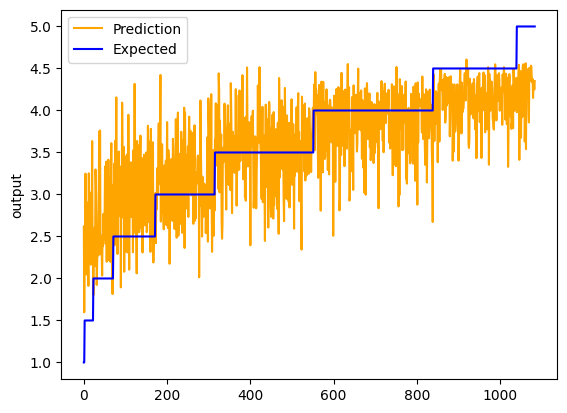

884. J'aime French Bakery eqNutOMnPqKa9QDAY6KfEw: rating: 3.0, predicted rating: [2.6504083]
548. New Orleans Hamburger & Seafood Co. niEm9LkcLOrvsDzjXD6WpQ: rating: 2.0, predicted rating: [3.159385]
857. CrossFit NOLA POn8Xzda_26vDYAmaEJMQA: rating: 3.0, predicted rating: [3.7598524]
121. Chinatown Market Shoe Repair And Tailor aNLr1j_3CZ46rqiUeLaQ-A: rating: 3.5, predicted rating: [3.8746724]
695. Mainland Grille 1sXN7Oxteo5dP5nwIDyO4w: rating: 4.0, predicted rating: [3.3729177]


In [3]:
# Finding the Best Model:
# Testing with:
# Activation: relu, sigmoid, tanh 
# Number of layers and neuron count for each layer 
# Optimizer: adam and sgd.

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set path and preprocess for functions
path = "./yelp_dataset/"

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define hyperparameters that were requested
activations = ['relu', 'sigmoid', 'tanh']
layer_neurons = [[100, 50], [100, 50, 25], [150, 75, 30], [100, 100, 100], [150, 100, 75, 50, 25]]  # Different layer configurations
optimizers = ['adam', 'sgd']

def Model_Test(activation, layer_neurons, optimizer):
    model = Sequential()
    model.add(Dense(layer_neurons[0], input_dim=x_train.shape[1], activation=activation))
    model.add(Dropout(0.1))
    for n in layer_neurons[1:]:
        model.add(Dense(n, activation=activation))
        model.add(Dropout(0.1))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    return model

best_rmse = float('inf')
best_model = None
best_params = {}

results = []

for activation in activations:
    for neurons in layer_neurons:
        for optimizer in optimizers:
            model = Model_Test(activation, neurons, optimizer)

            #
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
            model_filename = f"model_{activation}_{neurons}_{optimizer}.keras"
            checkpointer = ModelCheckpoint(filepath=model_filename, verbose=0, save_best_only=True) # save best model

            # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
            model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

            #
            model.load_weights(model_filename)

            # Predict and measure RMSE
            pred = model.predict(x_test)
            print(pred)
            score = np.sqrt(metrics.mean_squared_error(pred,y_test))
            print("Score (RMSE): {}".format(score))

            # Store results
            results.append({
                'Activation': activation,
                'Neurons': str(neurons),
                'Optimizer': optimizer,
                'RMSE': score
            })

            if score < best_rmse:
                best_rmse = score
                best_model = model
                best_params = {
                    'Activation': activation,
                    'Neurons': neurons,
                    'Optimizer': optimizer,
                    'RMSE': best_rmse
                }

# Table of Results
results_df = pd.DataFrame(results)
print(results_df)

print("\nBest Combination:")
print(best_params)

# Plot the chart without Rounding & RMSE
pred = best_model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) without Rounding: {}".format(score))
chart_regression(pred.flatten(), y_test)

# Displaying 5 Businesses Randomly

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 5 businesses
for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

Score (RMSE) with Rounding: 0.5517500042915344


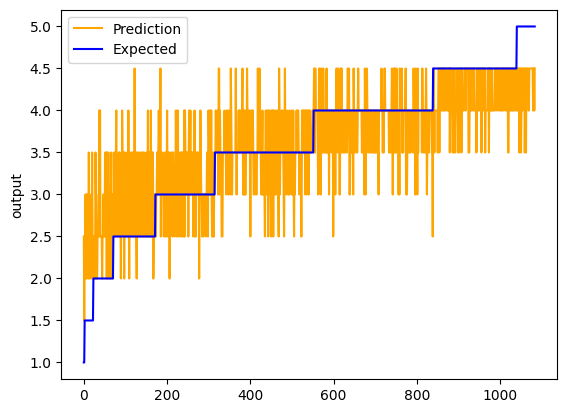

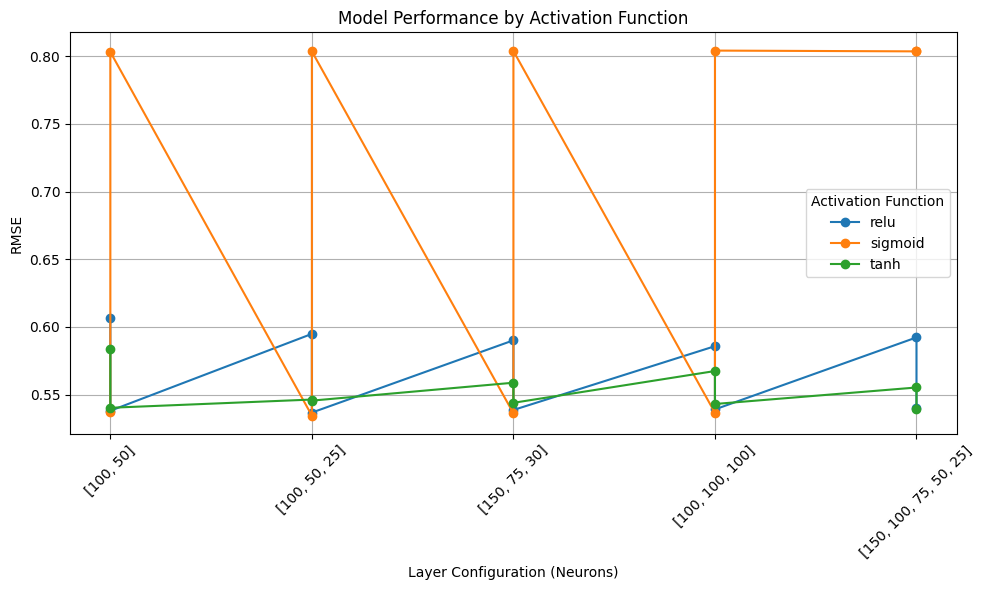

In [4]:

# Rounding up predicted values to .5
for i in pred:
    if i[0] < 5:
        i[0] = round(i[0]*2)/2
    if i[0] > 5:
        i[0] = 5

# Plot the chart with Rounding & RMSE
score2 = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) with Rounding: {}".format(score2))
chart_regression(pred.flatten(), y_test)

plot(results_df)

### Additional Feature: Different Review Counts
- This tests if changing the minimum review count for a business to qualify would change the RMSE
- Conclusion: Excluding businesses with less reviews lends to a better Model, with a lower RMSE

REG


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
52/52 - 3s - 63ms/step - loss: 5.0147 - val_loss: 1.3860
Epoch 2/1000
52/52 - 0s - 8ms/step - loss: 0.8758 - val_loss: 0.6363
Epoch 3/1000
52/52 - 1s - 11ms/step - loss: 0.4058 - val_loss: 0.4172
Epoch 4/1000
52/52 - 0s - 6ms/step - loss: 0.2715 - val_loss: 0.4245
Epoch 5/1000
52/52 - 0s - 6ms/step - loss: 0.1959 - val_loss: 0.3394
Epoch 6/1000
52/52 - 0s - 6ms/step - loss: 0.1564 - val_loss: 0.3365
Epoch 7/1000
52/52 - 0s - 8ms/step - loss: 0.1495 - val_loss: 0.3406
Epoch 8/1000
52/52 - 0s - 6ms/step - loss: 0.1324 - val_loss: 0.3182
Epoch 9/1000
52/52 - 0s - 5ms/step - loss: 0.1218 - val_loss: 0.3258
Epoch 10/1000
52/52 - 0s - 6ms/step - loss: 0.1133 - val_loss: 0.3223
Epoch 11/1000
52/52 - 0s - 6ms/step - loss: 0.1122 - val_loss: 0.3359
Epoch 12/1000
52/52 - 0s - 7ms/step - loss: 0.1008 - val_loss: 0.3201
Epoch 13/1000
52/52 - 0s - 6ms/step - loss: 0.1061 - val_loss: 0.3234
Epoch 14/1000
52/52 - 0s - 7ms/step - loss: 0.0957 - val_loss: 0.3078
Epoch 15/1000
52/52 - 0s - 

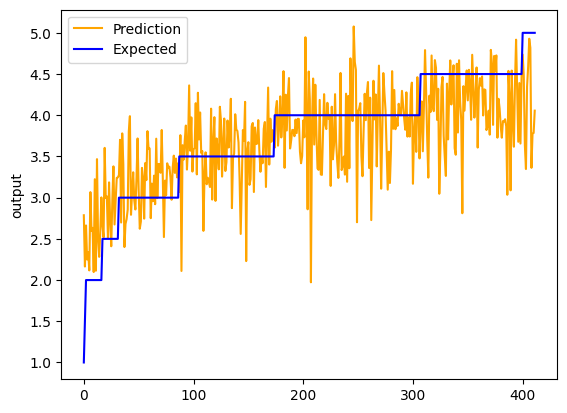

In [5]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Changing Minimum Review Count to 70

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 70 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 70]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 5 businesses
for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

# Plot the chart
chart_regression(pred.flatten(),y_test)


In [6]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Changing Minimum Review Count to 75

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 75 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 75]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

# Plot the chart
chart_regression(pred.flatten(), y_test)


REG
Epoch 1/1000


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 - 2s - 46ms/step - loss: 4.8346 - val_loss: 1.2252
Epoch 2/1000
49/49 - 0s - 5ms/step - loss: 0.9120 - val_loss: 0.6137
Epoch 3/1000
49/49 - 0s - 6ms/step - loss: 0.4711 - val_loss: 0.3558
Epoch 4/1000
49/49 - 0s - 6ms/step - loss: 0.2704 - val_loss: 0.2754
Epoch 5/1000
49/49 - 0s - 6ms/step - loss: 0.1970 - val_loss: 0.2723
Epoch 6/1000
49/49 - 1s - 12ms/step - loss: 0.1532 - val_loss: 0.2727
Epoch 7/1000
49/49 - 0s - 6ms/step - loss: 0.1281 - val_loss: 0.2978
Epoch 8/1000
49/49 - 0s - 7ms/step - loss: 0.1200 - val_loss: 0.2953
Epoch 9/1000


OSError: [Errno 22] Invalid argument: 'dnn/yelp.keras'

### Additional Feature: Per Category Model
- Groups Businesses by a specified category and creates a model with the affected businesses
- Conclusion: Placing into categories limits the training data and produces a less accurate RMSE

                  business_id                    name                 address  \
3      MTSW4McQd7CbVtyjqoe9mw      St Honore Pastries             935 Race St   
5      CF33F8-E6oudUQ46HnavjQ          Sonic Drive-In           615 S Main St   
8      k0hlBqXX-Bt0vf1op7Jr1w   Tsevi's Pub And Grill       8025 Mackenzie Rd   
9      bBDDEgkFA1Otx9Lfe7BZUQ          Sonic Drive-In     2312 Dickerson Pike   
11     eEOYSgkmpB90uNA7lDOMRA   Vietnamese Food Truck                           
...                       ...                     ...                     ...   
99988  j1CCLERiAMYSvCPhDmJN1g                 Dunkin'        3920 Ulmerton Rd   
99989  lkAzVdzEZE0jEU91PmvQhQ        Margaritas Grill    3320 Old Capitol Trl   
99992  xOrYm_QU2As1LTYhgsglmw    Sam-Witches and Such  6502 E Tanque Verde Rd   
99993  Z2_-rlxyXQsqcGXChydhlA  La Guera Mexican Grill          132 Garrett Rd   
99998  ccwhUs2fCLWTQLMa1L_xNQ            China Buffet           57 Fenton Plz   

               city state p

c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 - 2s - 39ms/step - loss: 3.9990 - val_loss: 0.9406
Epoch 2/1000
48/48 - 0s - 6ms/step - loss: 0.7909 - val_loss: 0.5022
Epoch 3/1000
48/48 - 0s - 6ms/step - loss: 0.4121 - val_loss: 0.3212
Epoch 4/1000
48/48 - 0s - 5ms/step - loss: 0.2412 - val_loss: 0.2625
Epoch 5/1000
48/48 - 0s - 6ms/step - loss: 0.1735 - val_loss: 0.2561
Epoch 6/1000
48/48 - 0s - 5ms/step - loss: 0.1308 - val_loss: 0.2493
Epoch 7/1000
48/48 - 0s - 5ms/step - loss: 0.1213 - val_loss: 0.2710
Epoch 8/1000
48/48 - 0s - 4ms/step - loss: 0.1038 - val_loss: 0.2523
Epoch 9/1000
48/48 - 0s - 5ms/step - loss: 0.0951 - val_loss: 0.2579
Epoch 10/1000
48/48 - 0s - 8ms/step - loss: 0.0909 - val_loss: 0.2481
Epoch 11/1000
48/48 - 0s - 5ms/step - loss: 0.0830 - val_loss: 0.2487
Epoch 12/1000
48/48 - 0s - 5ms/step - loss: 0.0862 - val_loss: 0.2913
Epoch 13/1000
48/48 - 0s - 5ms/step - loss: 0.0712 - val_loss: 0.2595
Epoch 14/1000
48/48 - 0s - 5ms/step - loss: 0.0666 - val_loss: 0.2785
Epoch 15/1000
48/48 - 0s - 6ms/step - los

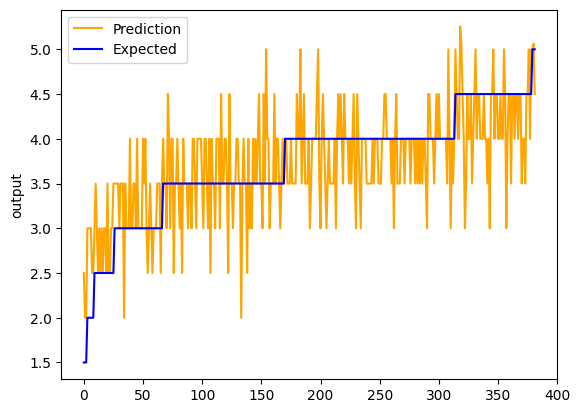

In [11]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Per Category 
ctgry = 'Restaurant'


# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df_0 = pd.read_json(business_Path, lines=True, nrows = 100000)
b_id = all_business_df[['business_id']]


# Filter to specific category
all_business_df = all_business_df_0[all_business_df_0['categories'].astype(str).str.contains(ctgry)]
print(all_business_df)

# Filter our businesses with less than 20 reviews
business_df = all_business_df[all_business_df['review_count'] >= 50]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) wihtout Rounding: {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 5 businesses
for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

# Rounding up predicted values to .5
for i in pred:
    if i[0] < 5:
        i[0] = round(i[0]*2)/2 

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) with Rounding: {}".format(score))

# Plot the chart
chart_regression(pred.flatten(), y_test)
